# Проект по А/B-тестированию

<b> Техническое задание: </b>
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.
      
<b> Данные: </b>
- ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
- final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
- final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- final_ab_participants.csv — таблица участников тестов.

<b> Задачи исследования: </b>
- Оценка корректности проведения теста;
- Анализ результатов теста.


## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
from plotly import graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
marketing_events = pd.read_csv('/Users/vintera/Git/projects/my_projects/dataset/project_12/ab_project_marketing_events.csv')
users = pd.read_csv('/Users/vintera/Git/projects/my_projects/dataset/project_12/final_ab_new_users.csv')
events = pd.read_csv('/Users/vintera/Git/projects/my_projects/dataset/project_12/final_ab_events.csv')
participants = pd.read_csv('/Users/vintera/Git/projects/my_projects/dataset/project_12/final_ab_participants.csv')

In [3]:
marketing_events
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
users.sample(5)
users.info()

,user_id,first_date,region,device
4495,D83BAC90A8B0FB8F,2020-12-07,EU,Android
25833,CD88317AE34FB058,2020-12-22,EU,iPhone
47623,3EE718562551ECDD,2020-12-12,EU,iPhone
19707,3849D3C6358DE467,2020-12-08,EU,iPhone
41586,C4F597DEE5EE5111,2020-12-11,EU,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [5]:
events.sample(5)
events.info()

,user_id,event_dt,event_name,details
161606,56BA4827C580636E,2020-12-14 18:50:41,product_page,NaN
41455,E54C78C12F2AB48E,2020-12-21 10:47:01,purchase,4.99
189241,C8AFE8BD75F501D3,2020-12-19 23:32:07,product_page,NaN
325850,77C7727D38B6C4FF,2020-12-17 23:56:01,login,NaN
270213,04A04DF2557A1D4E,2020-12-10 22:30:39,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [6]:
participants.sample(5)
participants.info()

,user_id,group,ab_test
5746,60FDFC4A00CAB216,B,recommender_system_test
6651,C67231B6FBA75D37,A,recommender_system_test
5075,6050D52AD58BC624,A,recommender_system_test
16128,F64F12490D6E91F6,B,interface_eu_test
12702,7C1181175AB272F3,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Вывод
При первичном знакомстве с данными, установленно, что даты указаны в формате object, что необходимо будет исправить в предобработке данных.

## Предобработка и исследование данных

In [7]:
# Преобразуем во всех датафреймах столбцы с датами в соответствующий формат
marketing_events['start_dt'] = marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events['finish_dt'] = marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
users['first_date'] = users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
events['event_dt'] = events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# В таблице с событиями добавим новый столбец, содержащий даты
events['date'] = events['event_dt'].astype('datetime64[D]')

In [8]:
# Проведем проверку на наличие полных дубликатов
users.duplicated().sum()
events.duplicated().sum()
participants.duplicated().sum()

0

0

0

### Комментарий
Дубликаты в данных отсутствуют

In [9]:
events.query('event_name != "purchase"').count()
events.query('event_name == "purchase"').count()

user_id       377577
event_dt      377577
event_name    377577
details            0
date          377577
dtype: int64

user_id       62740
event_dt      62740
event_name    62740
details       62740
date          62740
dtype: int64

### Комментарий
Пропуски имеются исключительно в столбце details таблицы событий, так как информация в нем содержится только для событий purchase. Не будем ничего менять.

### Подготовка данных в соответствии с ТЗ

In [10]:
users.first_date.min()
users.first_date.max()

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-23 00:00:00')

#### Комментарий
Набор новых пользователей производился до 23 декабря 2020. Оставим данные о пользователях набранных до 21 декабря включительно, в соответствии с требованиями ТЗ.

In [11]:
spec_users = users.query('first_date <= "2020-12-21"')
spec_users.describe()

,user_id,first_date,region,device
count,56470,56470,56470,56470
unique,56470,15,4,4
top,D72A72121175D8BE,2020-12-21 00:00:00,EU,Android
freq,1,6290,42340,25161
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-21 00:00:00,NaN,NaN


#### Комментарий
У нас осталось 56470 новых пользователей, набранных до 21 декабря

In [12]:
events.event_dt.describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

#### Комментарий
К сожалению данные о событиях собирались только до 2020-12-30 23:36:33, а по ТЗ дата остановки теста - 2021-01-04. Будем работать с имеющимися данными.

In [13]:
spec_participants = participants.query('ab_test == "recommender_system_test"')
len(spec_participants)

6701

#### Комментарий
6701 пользователь принял участие в "recommender_system_test". Проверим, повторялись ли пользователи в двух группах.

In [14]:
spec_participants.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [15]:
group_a = spec_participants.query('group == "A"')
group_b = spec_participants.query('group == "B"')

In [16]:
group_a.query('user_id in @group_b')['user_id'].count()
group_b.query('user_id in @group_a')['user_id'].count()

0

0

#### Комментарий
Повторяющиеся пользователи в группах А и В отсутствуют.

In [17]:
# Соединим полученные таблицы. Сначала к id из таблицы participants присоединим данные из таблицы users,
# затем к полученной таблице, также по id присоединим данные о совершенных событиях из таблицы events.
spec_df = spec_participants.merge(spec_users, how='inner', on='user_id').merge(events, how='left', on='user_id')

In [18]:
spec_df.user_id.nunique()
spec_df.groupby('group').agg({'user_id' : 'nunique'})

6701

,user_id
group,
A,3824
B,2877


#### Комментарий
К сожалению, в полученной таблице, после преобразований в соответствии с требованиями ТЗ осталось всего 3675 уникальных пользователей, что значительно меньше ожидаемых 6000. Сообщим о данной проблеме заказчику и продолжим исследование с имеющимися данными.

In [19]:
users_regions = spec_df.groupby('region').agg({'user_id': 'nunique'}).reset_index()
all_users_regions = users.groupby('region').agg({'user_id': 'nunique'}).reset_index()
users_regions = all_users_regions.merge(users_regions, how='inner', on='region')
users_regions['ratio'] = users_regions['user_id_y'] / users_regions['user_id_x']
users_regions = users_regions.rename(columns={"region": "Регион", 
                              "user_id_x": "Всего", 
                              "user_id_y": "Тестовая группа", 
                              "ratio": "Соотношение"})
display(users_regions.style.format({'Соотношение':"{0:.1%}"}))

,Регион,Всего,Тестовая группа,Соотношение
0,APAC,3153,72,2.3%
1,CIS,3155,55,1.7%
2,EU,46270,6351,13.7%
3,N.America,9155,223,2.4%


#### Комментарий
Касательно требования 15% новых пользователей из EU, тоже все не очень хорошо. Почти 95% пользователей из упомянутого региона и сокращать аудиторию до процентного соотношения из ТЗ не стоит, так как совсем не останется данных для исследования. Так же упомянем о данном обстоятельстве в отчете заказчику.

In [20]:
recomender_participants = participants.query('ab_test == "recommender_system_test"')
recomender_user_list = participants.query('ab_test == "recommender_system_test"')['user_id']
interface_participants = participants.query('ab_test == "interface_eu_test"')
interface_user_list = participants.query('ab_test == "interface_eu_test"')['user_id']

In [21]:
recomender_participants.query('user_id in @interface_user_list')['user_id'].count()
interface_participants.query('user_id in @recomender_user_list')['user_id'].count()

1602

1602

#### Комментарий
1602 пользователя участвовали одновременно в recommender_system_test и interface_eu_test. Участие в нескольких тестах одновременно, сказывается на адекватности проведения теста негативно. Сообщим об этом также заказчику.

### Вывод

При приведении данных к соответствию с требованиями ТЗ, была утрачена большая часть данных. Выявлены ошибки проведения теста (участие в нескольких тестах одновременно 1602 пользователями). О выявленных обстоятельствах необходимо подготовить соответствующий отчет и направить его заказчику исследования.

## Исследовательский анализ данных

### Конверсия в воронке на разных этапах

In [22]:
# Сгруппируем по событиям
all_events = spec_df.groupby('event_name').agg({'user_id' : 'count'}).sort_values(
    by = 'user_id', ascending = False).reset_index()
all_events

,event_name,user_id
0,login,11190
1,product_page,6930
2,purchase,3331
3,product_cart,3247


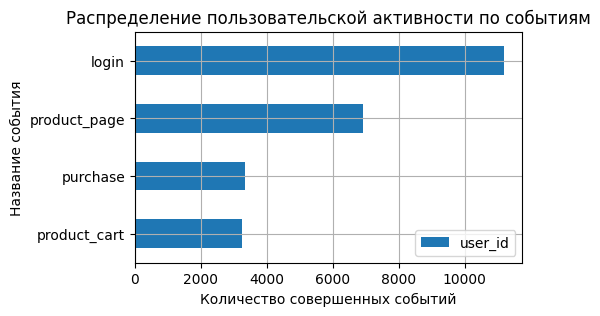

In [23]:
all_events.sort_values(by='user_id').plot(kind='barh', x='event_name', y='user_id', grid=True, figsize=(5,3))
plt.title('Распределение пользовательской активности по событиям')
plt.xlabel('Количество совершенных событий')
plt.ylabel('Название события');

#### Комментарий
В логе присутствует 4 вида событий. Начиная от самого популярного, это:
 - login (Авторизация);
 - product_page (Страница продукта);
 - purchase (Покупка);
 - product_cart (Продуктовая корзина).
 
Как ни странно, событий "Покупка", больше событий "Продуктовая корзина". Можно предположить, что у пользователей есть возможность совершения быстрой покупки, без перехода на страницу корзины.

#### Воронка всех событий

In [24]:
# Сгруппируем количество всех событий по датам
users_funnel = spec_df.pivot_table(
    index='date', 
    columns='event_name', 
    values='user_id',
    aggfunc='count')

In [25]:
# Построим график воронки событий, где значения, разбитые по датам, суммируем 
fig = go.Figure(go.Funnel(
    y = ["Авторизация",
         "Страница продукта", 
         "Продуктовая корзина", 
         "Покупка"],
    x = [users_funnel.login.sum(), 
         users_funnel.product_page.sum(), 
         users_funnel.product_cart.sum(), 
         users_funnel.purchase.sum()]
    ))
fig.show()

##### Вывод
От авторизации до страницы продукта доходит 61,9% пользователей, когда событие "продуктовая корзина" или "покупка" совершается у 29-30%% авторизовавшихся.

#### Воронка уникальных пользователей

In [26]:
# Создадим сводную таблицу, где значениями будут первые даты событий, совершенных пользователями
uniq_users = spec_df.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min').reset_index()

In [27]:
# Построим воронку и посчитаем пользователей, которые хоть раз совершали то или иное событие
fig = go.Figure(go.Funnel(
    y = ["Авторизация",
         "Страница продукта", 
         "Продуктовая корзина", 
         "Покупка"],
    x = [uniq_users.login.count(), 
         uniq_users.product_page.count(), 
         uniq_users.product_cart.count(), 
         uniq_users.purchase.count()]
    ))
fig.show()

##### Вывод
Исследуя воронку событий по уникальным пользователям, картина в процентном соотношении приблизительно такая же, как и была в первой воронке.

### Распределение количества событий на пользователя в выборках

In [28]:
# Разделим события по выборкам
event_A = spec_df.query('group == "A"').groupby('event_name').agg({'user_id': 'count'}).reset_index()
event_B = spec_df.query('group == "B"').groupby('event_name').agg({'user_id': 'count'}).reset_index()

In [29]:
# Посчитаем соотношение количества событий к количеству пользователей в группах А и В
event_A['ratio'] = (event_A['user_id'] / event_A['user_id'].sum() * 100).round(1)
event_A = event_A.rename(columns={"user_id":"count_A", "ratio": "ratio_A"})

In [30]:
event_B['ratio'] = (event_B['user_id'] / event_B['user_id'].sum() * 100).round(1)
event_B = event_B.rename(columns={"user_id":"count_B", "ratio": "ratio_B"})

In [31]:
event_AB = event_A.merge(event_B, how='inner', on='event_name')

In [32]:
event_AB = event_AB.sort_values(by='count_A', ascending=False)
event_AB

,event_name,count_A,ratio_A,count_B,ratio_B
0,login,8566,44.4,2624,48.6
2,product_page,5525,28.6,1405,26.0
3,purchase,2655,13.8,676,12.5
1,product_cart,2558,13.3,689,12.8


#### Комментарий
В целом распределение событий в группах почти одинаково, разница по событиям в среднем - 2-4%% между группами А и В. Однако стоит обратить внимание, что не считая события авторизации, по всем остальным событиям группа В немного проигрывает группе А.

In [33]:
# Построим воронки для групп, чтобы сравнить их конверсии
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Группа А',
    y=["Авторизация",
         "Страница продукта", 
         "Продуктовая корзина", 
         "Покупка"],
    x=event_AB['count_A'],
    textposition = "inside",
    textinfo = "value+percent initial"
    ))
fig.add_trace(go.Funnel(
    name = 'Группа В',
    y=["Авторизация",
         "Страница продукта", 
         "Продуктовая корзина", 
         "Покупка"],
    x=event_AB['count_B'],
    textposition = "inside",
    textinfo = "value+percent initial"
    ))

#### Комментарий
На полученном графике мы также можем заметить отставание группы В. Переход на страницу продукта у группы В на 10% ниже, корзины - на 5%, и совершение покупки на 4% ниже.

### Распределение числа событий по дням

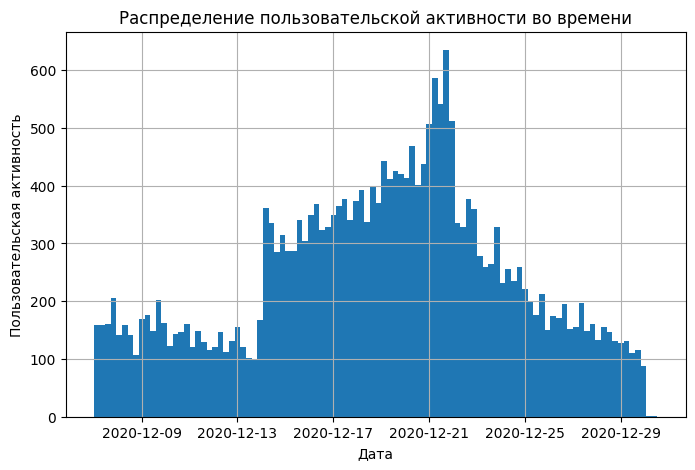

In [34]:
# Построим гистограмму распределения пользовательской активности во времени
spec_df['event_dt'].hist(bins=100, figsize=(8,5))
plt.title('Распределение пользовательской активности во времени')
plt.xlabel('Дата')
plt.ylabel('Пользовательская активность');

#### Комментарий
Как видно на графике, распределение событий неравномерно. Можно заметить скачки пользовательской активности 14 декабря, после чего активность держится на высоком уровне и 21 декабря - всплеск активности продержался сутки, после чего показатели идут на спад и возвращаются к начальным показателям к 29 декабря. Всплеск пользовательской активности может объясниться предстоящим католическим рождеством, когда пользователи покупают подарки своим родным и близким к празднику. 

In [35]:
spec_df.event_dt.describe()

count                   24698
unique                  16523
top       2020-12-09 19:01:05
freq                        6
first     2020-12-07 00:05:57
last      2020-12-30 12:42:57
Name: event_dt, dtype: object

In [36]:
# Проверим какие из маркетинговых мероприятий проводились одновременно с проведением теста
marketing_events.query('start_dt > "2020-12-07" and finish_dt > "2020-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


#### Вывод
"CIS New Year Gift Lottery" не повлияет на исследование, так как мероприятие началось в последний день сбора данных (тем более данные 30.12.20 собирались всего до полудня). "Christmas&New Year Promo", начавшееся 25 декабря, на пять дней пересекается с проведением теста ̶,̶ ̶о̶д̶н̶а̶к̶о̶ ̶н̶а̶ ̶г̶р̶а̶ф̶и̶к̶е̶ ̶м̶ы̶ ̶м̶о̶г̶л̶и̶ ̶з̶а̶м̶е̶т̶и̶т̶ь̶,̶ ̶ч̶т̶о̶ ̶в̶ ̶э̶т̶и̶ ̶д̶н̶и̶ ̶п̶о̶л̶ь̶з̶о̶в̶а̶т̶е̶л̶ь̶с̶к̶а̶я̶ ̶а̶к̶т̶и̶в̶н̶о̶с̶т̶ь̶ ̶н̶е̶ ̶п̶о̶к̶а̶з̶ы̶в̶а̶л̶а̶ ̶а̶н̶о̶м̶а̶л̶ь̶н̶ы̶х̶ ̶з̶н̶а̶ч̶е̶н̶и̶й̶,̶ ̶а̶ ̶т̶а̶к̶ж̶е̶ ̶у̶ч̶и̶т̶ы̶в̶а̶я̶,̶ ̶ч̶т̶о̶ ̶у̶ ̶н̶а̶с̶ ̶о̶с̶т̶а̶л̶о̶с̶ь̶ ̶п̶о̶л̶ь̶з̶о̶в̶а̶т̶е̶л̶е̶й̶ ̶м̶е̶н̶ь̶ш̶е̶ ̶о̶ж̶и̶д̶а̶е̶м̶о̶г̶о̶,̶ ̶н̶е̶ ̶б̶у̶д̶е̶м̶ ̶о̶т̶с̶е̶к̶а̶т̶ь̶ ̶д̶а̶н̶н̶ы̶е̶ ̶о̶ ̶с̶о̶б̶ы̶т̶и̶я̶х̶,̶ ̶с̶о̶в̶е̶р̶ш̶е̶н̶н̶ы̶х̶ ̶в̶ ̶э̶т̶о̶т̶ ̶в̶р̶е̶м̶е̶н̶н̶о̶й̶ ̶п̶р̶о̶м̶е̶ж̶у̶т̶о̶к̶к. Cообщим о данном обстоятельстве заказчику.

In [37]:
# Сократим исследуемые события до 25 декабря, чтобы данные не пересекались 
# с датами проведения Christmas&New Year Promo
spec_df_before_25_12 = spec_df.query('event_dt < "2020-12-25 00:00:00"')
spec_df_before_25_12.event_dt.describe()

count                   21370
unique                  14332
top       2020-12-09 19:01:05
freq                        6
first     2020-12-07 00:05:57
last      2020-12-24 23:58:32
Name: event_dt, dtype: object

## Оценка результатов A/B-тестирования

Сформулируем гипотезы для сравниваемых долей:
    
    H₀ - Нет оснований считать доли разными.

    H₁ - Между долями есть значимая разница.

In [38]:
# Создадим функцию, где в параметрах укажем датасет, название события, сравниваемые группы и значение альфа
alpha = 0.05
def Ztest(data, event):
    
    # Посчитаем количество совершенных событий и уникальных пользователей в группах
    gr1_event = data.query('group == "A" and @event in event_name').user_id.nunique()
    gr2_event = data.query('group == "B" and @event in event_name').user_id.nunique()
    gr1_users = data.query('group == "A"').user_id.nunique()
    gr2_users = data.query('group == "B"').user_id.nunique()
    
    # Посчитаем доли в группах и разницу между ними
    p1 = gr1_event / gr1_users
    p2 = gr2_event / gr2_users
    difference = p1 - p2
    
    p_combined = (gr1_event + gr2_event) / (gr1_users + gr2_users)
    
    # Посчитаем статистику в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1_users + 1/gr2_users))
    
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие: {}'.format(event))
    print('p-значение: ', round(p_value, 5))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [39]:
events_list = ['product_page', 'product_cart', 'purchase']

In [40]:
# В цикле прогоним названия событий для подготовленной функции
for event in events_list:
    Ztest(spec_df_before_25_12, event)
    print('-------------------------------------------------------------')
    print()

Событие: product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
-------------------------------------------------------------

Событие: product_cart
p-значение:  0.14535
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------------------------------------------------------

Событие: purchase
p-значение:  0.01759
Отвергаем нулевую гипотезу: между долями есть значимая разница
-------------------------------------------------------------



### Вывод
Статистически значимые различия между контрольной и тестовой группами при сравнении событий "product_page" и "purchase" присутствуют, чего нельзя сказать о событии "product_cart", где основания считать доли разными отсутствуют.

## Общий вывод и рекомендации бизнесу

Подводя итоги исследования, стоит отметить отсутствие возможности его проведения в соответствии с техническим заданием, так как предоставленные данные во многом не удовлетворяли его требования.
Таким образом: 
- Дата остановки теста по ТЗ: 2021-01-04, однако данные были предоставлены до 2020-12-30 12:42:57;
- Аудитория по ТЗ: 15% новых пользователей из региона EU, хотя в предоставленных данных  было 13.7% пользователей  из этого региона;

Помимо некачественных данных, можно отметить следующие обстоятельства, негативно сказывающиеся на результатах исследования:
- 1602 пользователя участвовали одновременно в recommender_system_test и interface_eu_test;
- Большая разница между количеством участников в группе A - 3824 и B - 2877;
- Совпадение дат проведения теста и маркетингового мероприятия "Christmas&New Year Promo".

Если судить по результатам теста с имеющимися данными, закрыв глаза на указанные выше обстоятельства, то тестовая группа В показала худшие результаты конверсий в события по сравнению с группой А: 
- "Переход на страницу продукта" на 10% ниже; 
- "Страница корзины" - на 5% ниже; 
- "Совершение покупки" - на 4% ниже.

При проведении проверки статистической разницы долей z-критерием, установленно:
- "Переход на страницу продукта" - между долями есть разница; 
- "Страница корзины" - нет оснований считать доли разными; 
- "Совершение покупки" - между долями есть разница.

Учитывая изложенное и подводя итоги исследования, имеются достаточные основания считать А/В - тестирование не состоявшимся из-за наличия большого количества ошибок, о которых было упомянуто ранее. Для получения более качественных результатов, 